In [1]:
import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn' # Gets rid of SettingWithCopy warnings
pd.options.display.float_format = '{:.1f}'.format # only print one decimal place

import matplotlib.pyplot as plt
from matplotlib.colors import rgb2hex
from matplotlib.colors import ListedColormap
%matplotlib inline

import seaborn as sns
sns.set(font_scale=1.5) # have bigger fonts by default

import ipywidgets as widgets
from ipywidgets import interact
from IPython.display import clear_output

import random

## Load Forecast Data

In [51]:
people = pd.read_csv('../data/forecast/people.csv', 
                          index_col='id', 
                          parse_dates=['updated_at'],
                          infer_datetime_format=True)

# assign missing capacities as 6.4 hour days, 5 days per week
people['weekly_capacity'].fillna(6.4*5*60*60, inplace=True)

# convert capacity into FTE at 6.4 hrs/day
people['weekly_capacity'] = people['weekly_capacity']/(6.4*5*60*60)

# remove project managers
people = people[people.roles != "['Research Project Manager']"]

# manually remove misc cases
people = people[people.first_name != 'Joel']
people = people[people.first_name != 'Angus']
people = people[people.first_name != 'Amaani']

In [3]:
projects = pd.read_csv('../data/forecast/projects.csv', 
                          index_col='id', 
                          parse_dates=['updated_at','start_date','end_date'],
                          infer_datetime_format=True)

projects.shape

(90, 12)

In [4]:
placeholders = pd.read_csv('../data/forecast/placeholders.csv', 
                          index_col='id',
                          parse_dates=['updated_at'],
                          infer_datetime_format=True)

placeholders.shape

(8, 5)

In [5]:
clients = pd.read_csv('../data/forecast/clients.csv', 
                          index_col='id', 
                          parse_dates=['updated_at'],
                          infer_datetime_format=True)

clients.shape

(29, 5)

In [6]:
assignments = pd.read_csv('../data/forecast/assignments.csv', 
                          index_col='id', 
                          parse_dates=['start_date','end_date','updated_at'],
                          infer_datetime_format=True)

# convert assignments in seconds per day to fractions of 6.4 hour days
assignments['allocation'] = assignments['allocation']/(6.4*60*60)

# Find the earliest and latest date in the data
date_range = pd.date_range(start=assignments['start_date'].min(),
                           end=assignments['end_date'].max(),
                           freq='D')

assignments.shape

(177, 11)

## Functions to merge and slice people/project data

In [7]:
def get_person_name(person_id):
    """Get the full name of someone from their person_id"""
    return people.loc[person_id,'first_name'] + ' ' + people.loc[person_id, 'last_name']


def get_person_id(first_name, last_name=None):
    """Get the person_id of someone from their first_name and last_name."""
    if last_name is None:
        person_id = people.loc[(people['first_name']==first_name)]
    
        if len(person_id) != 1:
            raise ValueError('Could not unique person with name '+first_name)

    else:
        person_id = people.loc[(people['first_name']==first_name) & (people['last_name']==last_name)]
    
        if len(person_id) != 1:
            raise ValueError('Could not unique person with name '+first_name+' '+last_name)

    return person_id.index[0]


def get_project_name(project_id):
    """Get the name of a project from its project_id"""
    return projects.loc[project_id, 'name']


def get_project_id(project_name):
    return projects.index[projects.name==project_name][0]


def get_placeholder_name(placeholder_id):
    return placeholders.loc[placeholder_id, 'name']
    

def get_placeholder_id(placeholder_name):
    return placeholders.index[placeholders.name==placeholder_name][0]


def get_name(id_value, id_type):
    if id_type=='person_id':
        return get_person_name(id_value)
    elif id_type=='project_id':
        return get_project_name(id_value)
    elif id_type=='placeholder_id':
        return get_placeholder_name(id_value)
    else:
        raise ValueError('id_type must be person_id, project_id or placeholder_id')

    
def select_date_range(df, start_date, end_date): 
    """Extract a range of dates from a dataframe with a datetime index, 
    then remove any columns which are left empty (full of zeros)."""
    mask = (df.index >= start_date) & (df.index <= end_date)
    df_slice = df.loc[mask]
    
    nonzero_cols = df_slice.columns[df_slice.sum()!=0]
    df_slice = df_slice[nonzero_cols]
        
    return df_slice

In [8]:
def get_allocations(id_column):
    if id_column=='person_id':
        grouped_allocations = assignments.groupby(['person_id','project_id','start_date','end_date']).allocation.sum()
        id_values = people.index
        ref_column = 'project_id'
        
    elif id_column=='project_id':
        grouped_allocations = assignments.groupby(['project_id','person_id','start_date','end_date']).allocation.sum()
        id_values = projects.index
        ref_column = 'person_id'
        
    elif id_column=='placeholder_id':
        grouped_allocations = assignments.groupby(['placeholder_id','project_id','start_date','end_date']).allocation.sum()
        id_values = placeholders.index
        ref_column = 'project_id'
        
    else:
        raise ValueError('id_column must be person_id, project_id or placeholder_id')
            
    
    allocations = {}
    
    for idx in id_values:        
        # check whether the this id has any assignments, i.e. whether the id
        # exists in the index (get_level_values to deal with MultiIndex)
        if idx in grouped_allocations.index.get_level_values(0):
            # get the allocations
            id_allocs = grouped_allocations.loc[idx]

            # unstack the MultiIndex
            id_allocs = id_allocs.reset_index()

            # Initialise dataframe to store results
            id_alloc_days = pd.DataFrame(index=date_range, columns=id_allocs[ref_column].unique())
            id_alloc_days.fillna(0,inplace=True)

            # Loop over each assignment
            for _,row in id_allocs.iterrows():
                # Create the range of dates that this assignment corresponds to, with daily frequency
                dates = pd.date_range(start=row['start_date'], end=row['end_date'], freq='D')

                # Add the allocation to the corresponding project for the range of dates.
                id_alloc_days.loc[dates, row[ref_column]] += row['allocation']

        else:
            # no projects, just make an empty dataframe..
            id_alloc_days = pd.DataFrame(index=date_range)

        # Add the person's name as a label - just nice for printing later.
        id_alloc_days.columns.name = get_name(idx, id_column)
        
        allocations[idx] = id_alloc_days
    
    # total assignment each day
    totals = pd.DataFrame(index=date_range, columns=id_values)
    for idx in allocations.keys():
        totals[idx] = allocations[idx].sum(axis=1)

    
    return allocations, totals

In [9]:
people_allocations, people_totals = get_allocations('person_id')

project_allocations, project_totals = get_allocations('project_id')

placeholder_allocations, placeholder_totals = get_allocations('placeholder_id')

## Show Someone's Project Assignment

In [10]:
def plot_person_allocations(person_id, start_date, end_date):
    """Make a stacked area plot of a person's project allocations between
    a start date and an end date."""
    
    # get the person's project allocations
    df = people_allocations[person_id]
    
    # extract the date range of interest
    df = select_date_range(df, start_date, end_date)
    
    # replace project_ids in column names with their project names
    df.columns = [get_project_name(project_id) for project_id in df.columns]
    df.columns.name = get_person_name(person_id)
    
    # check whether there's anything to plot
    rows,cols = df.shape
    if rows>0 and cols>0:
        df = df.resample('W-MON').mean()

        # plot the data
        ax = plt.figure(figsize=(15,5)).gca()
        df.plot.area(ax=ax, linewidth=0)

        xlim = ax.get_xlim()
        #plt.plot(xlim,[0.8, 0.8], 'k--', linewidth=3)
        plt.plot(xlim,[1, 1], 'k--', linewidth=3)
        plt.xlim(xlim)
        plt.ylim([0, max([1, 1.1*df.sum(axis=1).max()])])

        plt.title(get_person_name(person_id))
        plt.ylabel('Proportion 6.4hr days')
        plt.xticks()
        plt.legend(title='',loc='best')
        plt.show()
        
    else:
        print('Nothing to plot.')


def highlight_allocations(df):
    """Function to conditionally style a data frame:
        Total allocations above 1.0 are highlighted red,
        above 0.8 orange, 0.8 yellow, and below 0.8 green.
        
        Individual project allocations are coloured blue when
        the person is active and grey when inactive on that project"""
    
    def highlight_tot(series):
        """function used to apply highlighting to the TOTAL column"""
        is_over = series>1.01
        is_marginal = (series>0.81) & (is_over==False)
        is_under = series<0.79

        style = []
        for i in range(len(series)):
            if is_over[i]:
                style.append('background-color: red')
            elif is_marginal[i]:
                style.append('background-color: orange')
            elif is_under[i]:
                style.append('background-color: lime')
            else:
                style.append('background-color: yellow')

        return style
    
    
    def highlight_active(series):
        """Function used to apply highlighting to all columns except the TOTAL column"""
        style=[]
        for i in range(len(series)):
            if series[i]>0:
                style.append('background-color: lightblue')
            else:
                style.append('background-color: dimgrey')
                
        return style
    
    # Apply the style. In order:
    #   - display percentages to nearest integer
    #   - centre align text
    #   - centre align and word wrap column names
    #   - conditional formatting for TOTAL column
    #   - conditional formatting for remaining columns
    return df.style.\
           format('{:.0%}').\
           set_properties(**{'text-align': 'center'}).\
           set_table_styles([dict(selector="th",props=[('max-width', '100px'), 
                                                       ('text-align','center')])]).\
           apply(highlight_active, subset=df.columns.drop('TOTAL')).\
           apply(highlight_tot, subset=['TOTAL'])


def table_person_allocations(person_id, start_date, end_date, freq='MS'):
    """Display a formatted table of a person's project allocations in a given
    date range, and with a certain date frequency. E.g. if freq='MS' each row
    will correspond to a month. 'D' for days, or 'W-MON' for weeks."""
    
    # extract the person's allocations, and replace ids with names
    df = people_allocations[person_id].copy()
    df.columns = [get_project_name(project_id) for project_id in df.columns]
    df.columns.name = get_person_name(person_id)
    
    # add the person's total project assignment to the data frame
    df['TOTAL'] = people_totals[person_id]

    # slice the given date range from the dataframe
    df = select_date_range(df, start_date, end_date)
    
    # check there's something to display
    rows,cols = df.shape
    if rows>0 and cols>0:
        # resample the rows to the given date frequency
        df = df.resample(freq).mean()

        # change date format for prettier printing
        df = pd.DataFrame(df, index=df.index.strftime("%Y-%m-%d"))

        # display the table
        display(highlight_allocations(df))
        
    else:
        print('Nothing to print.')

Dropdown(description='Person:', index=11, options=('Camila Rangel Smith', 'David Beavan', 'Eric Daub', 'Evelin…

DatePicker(value=datetime.datetime(2019, 1, 1, 0, 0), description='Start Date:')

DatePicker(value=datetime.datetime(2019, 12, 31, 0, 0), description='End Date:')

RadioButtons(description='Frequency:', options=('Monthly', 'Weekly', 'Daily'), value='Monthly')

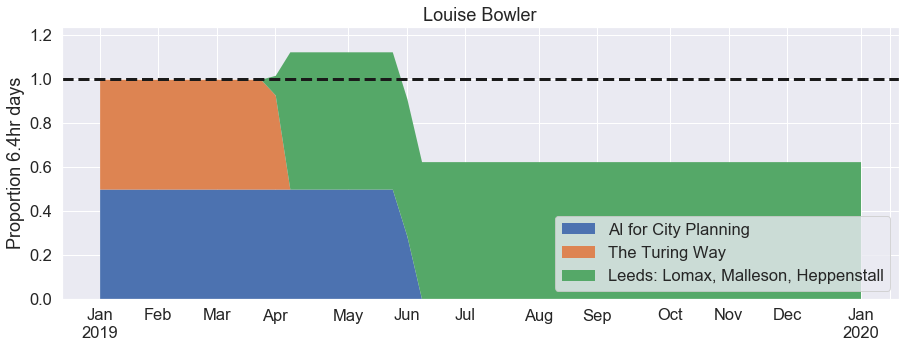

Louise Bowler,AI for City Planning,The Turing Way,"Leeds: Lomax, Malleson, Heppenstall",TOTAL
2019-01-01,50%,50%,0%,100%
2019-02-01,50%,50%,0%,100%
2019-03-01,50%,50%,0%,100%
2019-04-01,50%,0%,62%,112%
2019-05-01,50%,0%,62%,112%
2019-06-01,0%,0%,62%,62%
2019-07-01,0%,0%,62%,62%
2019-08-01,0%,0%,62%,62%
2019-09-01,0%,0%,62%,62%
2019-10-01,0%,0%,62%,62%


In [11]:
# dropdown list to select a person
widg_person_select = widgets.Dropdown(options=sorted([get_person_name(person_id) for person_id in people.index]),
                                 description='Person:')

# date picker to choose a start date
widg_person_start = widgets.DatePicker(
                    description='Start Date:',
                    value=pd.datetime(2019,1,1),
                    disabled=False
                )

# date picker to choose an end date
widg_person_end = widgets.DatePicker(
                    description='End Date:',
                    value=pd.datetime(2019,12,31),
                    disabled=False
                )

# radio buttons to choose the frequency of dates to display in the table
widg_person_freq = widgets.RadioButtons(
    options=['Monthly', 'Weekly', 'Daily'],
    value='Monthly',
    description='Frequency:',
    disabled=False
)


def widg_person_select_alloc(change):
    """Function called by widgets to update the person allocation plot and table.
    The change argument isn't used but it's required for widget.observe."""
    
    # clear the previous output, then display the widgets again
    clear_output()
    display(widg_person_select, widg_person_start, widg_person_end, widg_person_freq)
    
    # get the person_id from the selected full name (need to first split into first and last names)
    names = widg_person_select.value.split()
    person_id = get_person_id(names[0], ' '.join(names[1:]))
    
    # get the selected dates
    start_date = pd.to_datetime(widg_person_start.value)
    end_date = pd.to_datetime(widg_person_end.value)
    
    # get the selected date frequency
    freq_dict = {'Monthly':'MS','Weekly':'W-MON','Daily':'D'}
    freq = freq_dict[widg_person_freq.value]
    
    # plot the person allocations
    plot_person_allocations(person_id, start_date, end_date)
    
    # print the person allocations table
    table_person_allocations(person_id, start_date, end_date, freq)

# setup the event listeners
widg_person_select.observe(widg_person_select_alloc, names='value')
widg_person_start.observe(widg_person_select_alloc, names='value')
widg_person_end.observe(widg_person_select_alloc, names='value')
widg_person_freq.observe(widg_person_select_alloc, names='value')

# display the widgets
display(widg_person_select, widg_person_start, widg_person_end, widg_person_freq)

# show results with initial values
widg_person_select_alloc(None)

## Show Everyone's Total Project Allocation Over Time

In [12]:
def highlight_tot(series):
    """Function used to apply conditional formatting to cells based on their values.
    Currently: below 0.8=green, 0.8=yellow, above 0.8=orange, above 1.0=red."""
    is_over = series>1.01
    is_marginal = (series>0.81) & (is_over==False)
    is_under = series<0.79

    style = []
    for i in range(len(series)):
        if is_over[i]:
            style.append('background-color: red')
        elif is_marginal[i]:
            style.append('background-color: orange')
        elif is_under[i]:
            style.append('background-color: lime')
        else:
            style.append('background-color: yellow')

    return style


def table_team_allocations(change):
    """Function to display a table of each team member's (columns) allocation over time (rows).
    Change argument not used - just to have function with required format for widget.observe"""
    # clear the previous output, then display the widgets again
    clear_output()
    display(widg_team_start, widg_team_end, widg_team_freq)

    # initialise df
    df = people_totals.copy()

    # mask used to select date range of interest
    mask = (df.index >= pd.to_datetime(widg_team_start.value)) & (df.index <= pd.to_datetime(widg_team_end.value))

    # get the selected date frequency
    freq_dict = {'Monthly':'MS','Weekly':'W-MON','Daily':'D'}
    freq = freq_dict[widg_team_freq.value]
    
    # extract slice of dates, and resample to selected frequency
    df = df[mask].resample(freq).mean()

    # replace person ids with names
    df.columns = [get_person_name(person_id) for person_id in df.columns]

    # format dates nicely
    if freq=='MS':
        df = pd.DataFrame(df, index=df.index.strftime("%b-%Y"))
    elif freq=='W-MON':
        df = pd.DataFrame(df, index=df.index.strftime("%d-%b-%Y"))
    else:
        df = pd.DataFrame(df, index=df.index.strftime("%Y-%m-%d"))

    # display the table with applied styling. In order:
    #   - sort columns by first name, display percentages to nearest integer
    #   - centre align text
    #   - centre align and word wrap column names
    #   - conditional formatting based on values
    display(df[sorted(df.columns)].style.format('{:.0%}').\
             set_properties(**{'text-align': 'center'}).\
             set_table_styles([dict(selector="th",props=[('max-width', '100px'), 
                                                           ('text-align','center')])]).\
             apply(highlight_tot)) 
    

# date picker to choose a start date
widg_team_start = widgets.DatePicker(
                    description='Start Date:',
                    value=pd.datetime(2019,1,1),
                    disabled=False
                )

# date picker to choose an end date
widg_team_end = widgets.DatePicker(
                    description='End Date:',
                    value=pd.datetime(2019,12,31),
                    disabled=False
                )

# radio buttons to choose the frequency of dates to display in the table
widg_team_freq = widgets.RadioButtons(
    options=['Monthly', 'Weekly', 'Daily'],
    value='Monthly',
    description='Frequency:',
    disabled=False
)

# setup the event listeners
widg_team_start.observe(table_team_allocations, names='value')
widg_team_end.observe(table_team_allocations, names='value')
widg_team_freq.observe(table_team_allocations, names='value')

# display the widgets
display(widg_team_start, widg_team_end, widg_team_freq)

# show results with initial values
table_team_allocations(None)

DatePicker(value=datetime.datetime(2019, 1, 1, 0, 0), description='Start Date:')

DatePicker(value=datetime.datetime(2019, 12, 31, 0, 0), description='End Date:')

RadioButtons(description='Frequency:', options=('Monthly', 'Weekly', 'Daily'), value='Monthly')

,Camila Rangel Smith,David Beavan,Eric Daub,Evelina Gabasova,Giovanni Colavizza,Jack Roberts,James Geddes,James Hetherington,James Robinson,Jim Madge,Kasra Hosseini,Louise Bowler,Martin O'Reilly,May Yong,Miguel Morin,Nick Barlow,Oliver Strickson,Oscar Giles,Radka Jersakova,Sarah Gibson,Timothy Hobson,Tomas Lazauskas
Jan-2019,100%,100%,90%,162%,100%,0%,100%,125%,100%,100%,0%,100%,100%,100%,162%,100%,125%,0%,100%,100%,100%,100%
Feb-2019,100%,100%,100%,162%,100%,0%,100%,125%,100%,100%,49%,100%,100%,100%,162%,100%,125%,0%,100%,100%,100%,100%
Mar-2019,100%,100%,94%,162%,100%,0%,100%,119%,94%,100%,125%,100%,100%,100%,162%,100%,125%,0%,100%,100%,100%,100%
Apr-2019,112%,100%,0%,162%,75%,0%,50%,25%,100%,50%,0%,112%,0%,50%,162%,100%,62%,0%,100%,50%,100%,50%
May-2019,112%,100%,0%,162%,75%,0%,50%,25%,100%,0%,0%,112%,0%,50%,162%,100%,62%,0%,100%,50%,100%,50%
Jun-2019,112%,100%,0%,162%,75%,0%,0%,25%,100%,0%,0%,62%,0%,0%,0%,100%,0%,0%,100%,50%,100%,50%
Jul-2019,112%,100%,0%,162%,75%,0%,0%,25%,100%,0%,0%,62%,0%,0%,0%,100%,0%,0%,100%,50%,100%,50%
Aug-2019,112%,100%,0%,162%,75%,0%,0%,25%,100%,0%,0%,62%,0%,0%,0%,100%,0%,0%,50%,50%,100%,50%
Sep-2019,112%,100%,0%,162%,75%,0%,0%,25%,100%,0%,0%,62%,0%,0%,0%,100%,0%,0%,50%,50%,100%,50%
Oct-2019,112%,100%,0%,162%,75%,0%,0%,25%,100%,0%,0%,62%,0%,0%,0%,100%,0%,0%,50%,50%,100%,50%


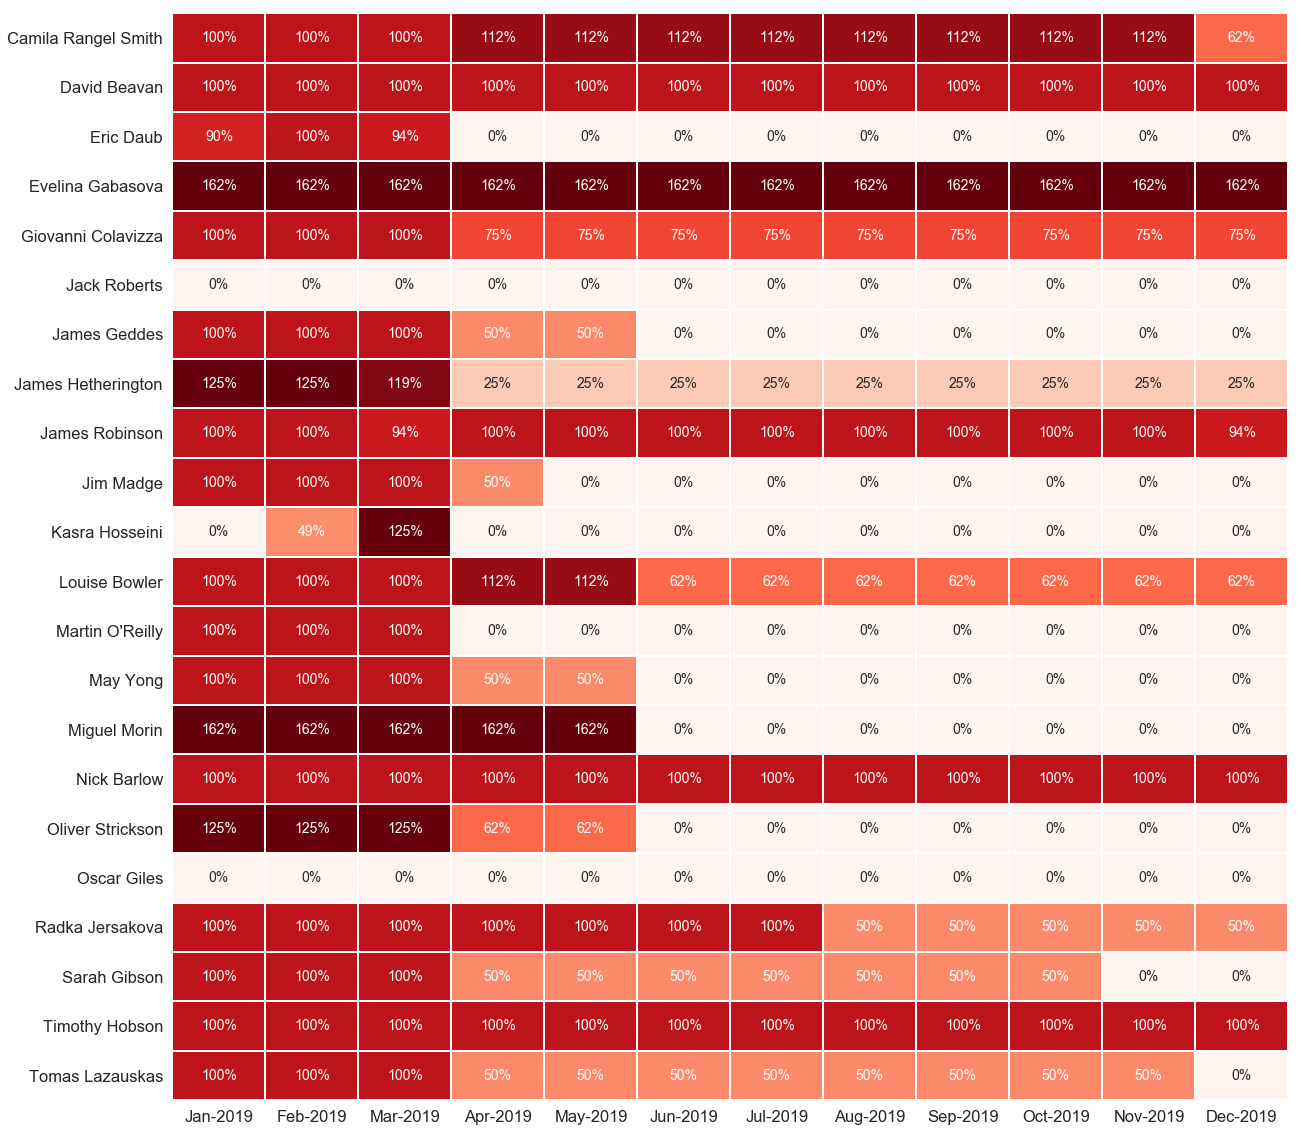

In [13]:
# total allocation as a heatmap rather than as a table
df = people_totals.copy()
mask = (df.index >= pd.to_datetime(widg_team_start.value)) & (df.index <= pd.to_datetime(widg_team_end.value))
df = df[mask].resample('MS').mean()
df.columns = [get_person_name(person_id) for person_id in df.columns]
df = pd.DataFrame(df, index=df.index.strftime("%b-%Y"))

plt.figure(figsize=(20,20))
sns.heatmap(df.T.sort_index(), linewidths=1,
            cmap='Reds', vmin=0, vmax=1.25, cbar=False,
            annot=True, fmt='.0%', annot_kws={'fontsize': 14})

## Equivalent of People Sheet in Martin's Spreadsheet

In [14]:
# Create a dataframe with everyone's 1st, 2nd and 3rd projects based on allocated time.

alloc_names = {}

# select range and frequency of dates to display
start_date = pd.datetime(2018,11,1)
end_date = pd.datetime(2021,3,1)
freq = 'MS'

# set of unique project names used for cell colouring later
project_names = set()

# for each person
for person_id in people_allocations.keys():
    
    # get the person's project allocations
    df = people_allocations[person_id].copy()

    # extract the date range of interest
    df = select_date_range(df, start_date, end_date)
    
    # check there are project allocations to display
    rows,cols = df.shape
    if rows>0 and cols>0:    
        # replace project_ids in column names with their project names
        df.columns = [get_project_name(project_id) for project_id in df.columns]
        df.columns.name = get_person_name(person_id)
        
        # update the set of project names
        [project_names.add(proj) for proj in df.columns]

        # resample the data to the given date frequency
        df = df.resample(freq).mean()
        
        # initialise data frame to store person's projects ranked by time assignment
        df_ranked = pd.DataFrame(index=df.index, columns=['1st','2nd','3rd'])
        
        # for each date period
        for date in df_ranked.index:
            
            # rank the project for this date period by time allocation
            sorted_projects = df.loc[date, df.loc[date]>0].sort_values(ascending=False)

            # if no project in this period - empty cell
            if len(sorted_projects)==0:
                df_ranked.loc[date, :] = ''
            
            else:
                # Fill 1st project with format <PROJECT_NAME> (<PROJECT_ALLOCATION>)
                df_ranked.loc[date,'1st'] = sorted_projects.index[0] + ' ({:.1f})'.format(sorted_projects.iloc[0])
                
                # fill the 2nd project, if one exists
                if len(sorted_projects)>1:
                    df_ranked.loc[date,'2nd'] = sorted_projects.index[1] + ' ({:.1f})'.format(sorted_projects.iloc[1])
                else:
                    df_ranked.loc[date, ['2nd','3rd']] = ''
                    
                # Fill remaining projects, if more exist, with format <NAME_3> (<ALLOCATION_3>) / <NAME_4> (<ALLOCATION_4>) etc.
                if len(sorted_projects)>2:
                    proj_str = ''
                    for i in range(2, len(sorted_projects)):
                        proj_str = proj_str + sorted_projects.index[i] + ' ({:.1f})'.format(sorted_projects.iloc[i]) + ' / '
                    
                    df_ranked.loc[date,'3rd'] = proj_str[:-3]

                else:
                    df_ranked.loc[date, '3rd'] = ''
        
        # If person doesn't have any 2nd or 3rd projects, remove those columns
        if df_ranked['2nd'].str.len().sum()==0:
            df_ranked.drop('2nd',axis=1,inplace=True)
        
        if df_ranked['3rd'].str.len().sum()==0:
            df_ranked.drop('3rd',axis=1,inplace=True)
                
        # format dates nicely
        if freq=='MS':
            df_ranked = pd.DataFrame(df_ranked, index=df_ranked.index.strftime("%b-%Y"))
        elif freq=='W-MON':
            df_ranked = pd.DataFrame(df_ranked, index=df_ranked.index.strftime("%d-%b-%Y"))
        else:
            df_ranked = pd.DataFrame(df_ranked, index=df_ranked.index.strftime("%Y-%m-%d"))
        
        # store the person's allocations - transpose to get rows as people and columns as dates
        alloc_names[get_person_name(person_id)] = df_ranked.T
        
# merge everyone together into one large dataframe, sorted by first name
alloc_names = pd.concat(alloc_names).sort_index()

In [15]:
# Functions to generate some distinct colours, from:
# https://gist.github.com/adewes/5884820
def get_random_color(pastel_factor = 0.5):
    return [(x+pastel_factor)/(1.0+pastel_factor) for x in [random.uniform(0,1.0) for i in [1,2,3]]]

def color_distance(c1,c2):
    return sum([abs(x[0]-x[1]) for x in zip(c1,c2)])

def generate_new_color(existing_colors,pastel_factor = 0.5):
    max_distance = None
    best_color = None
    for i in range(0,100):
        color = get_random_color(pastel_factor = pastel_factor)
        if not existing_colors:
            return color
        best_distance = min([color_distance(color,c) for c in existing_colors])
        if not max_distance or best_distance > max_distance:
            max_distance = best_distance
            best_color = color
    return best_color

colors = {}
for proj in project_names:
    colors[proj] = generate_new_color(colors.values(), pastel_factor=0.5)

# Assign a different colour to each project
def highlight_proj(cell):
    cell = cell[:-6]
    if cell in project_names:
        return 'background-color: '+rgb2hex(colors[cell])
    else:
        return 'background-color: white'

styled_df = alloc_names.style.applymap(highlight_proj)

# display
styled_df.to_excel('people_coloured_projects.xlsx')
display(styled_df)

## Project Allocations

Text(0.5, 1.0, 'Total Resource Allocation')

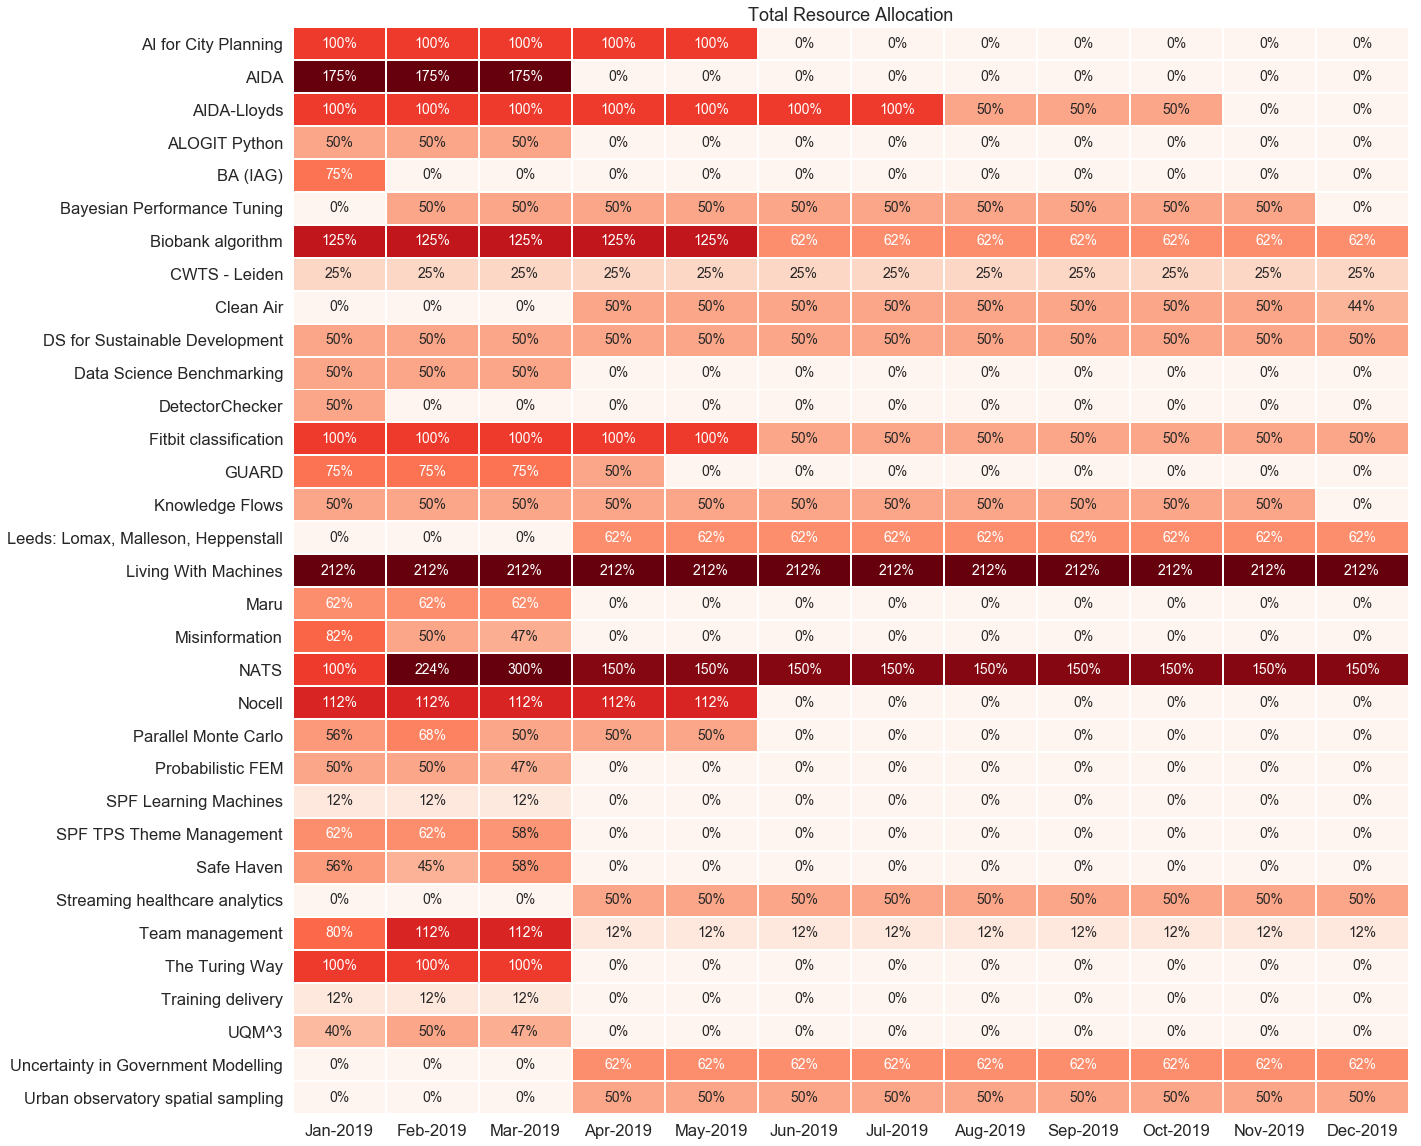

In [16]:
df = project_totals.copy()
mask = (df.index >= pd.to_datetime(widg_team_start.value)) & (df.index <= pd.to_datetime(widg_team_end.value))
df = df[mask].resample('MS').mean()
df = df.loc[:, df.sum()>0]
df.columns = [get_project_name(project_id) for project_id in df.columns]
df = pd.DataFrame(df, index=df.index.strftime("%b-%Y"))

plt.figure(figsize=(20,20))
sns.heatmap(df.T.sort_index(), cmap='Reds', vmax=1.6, linewidths=1, cbar=False,
            annot=True, annot_kws={'fontsize':14}, fmt='.0%')
plt.title('Total Resource Allocation')

In [65]:
# Project requirements = Project assignments + Resource required assignments
project_reqs = project_totals.copy()

# add resource req info from placeholders
resource_req_ids = placeholders[placeholders.name.str.lower().str.contains('resource required')].index

for idx in resource_req_ids:
    allocs = placeholder_allocations[idx]
    
    for col in allocs.columns:
            project_reqs[col] += allocs[col]
            
            
project_resreq = project_reqs - project_totals

Text(0.5, 1.0, 'Active and Upcoming Projects')

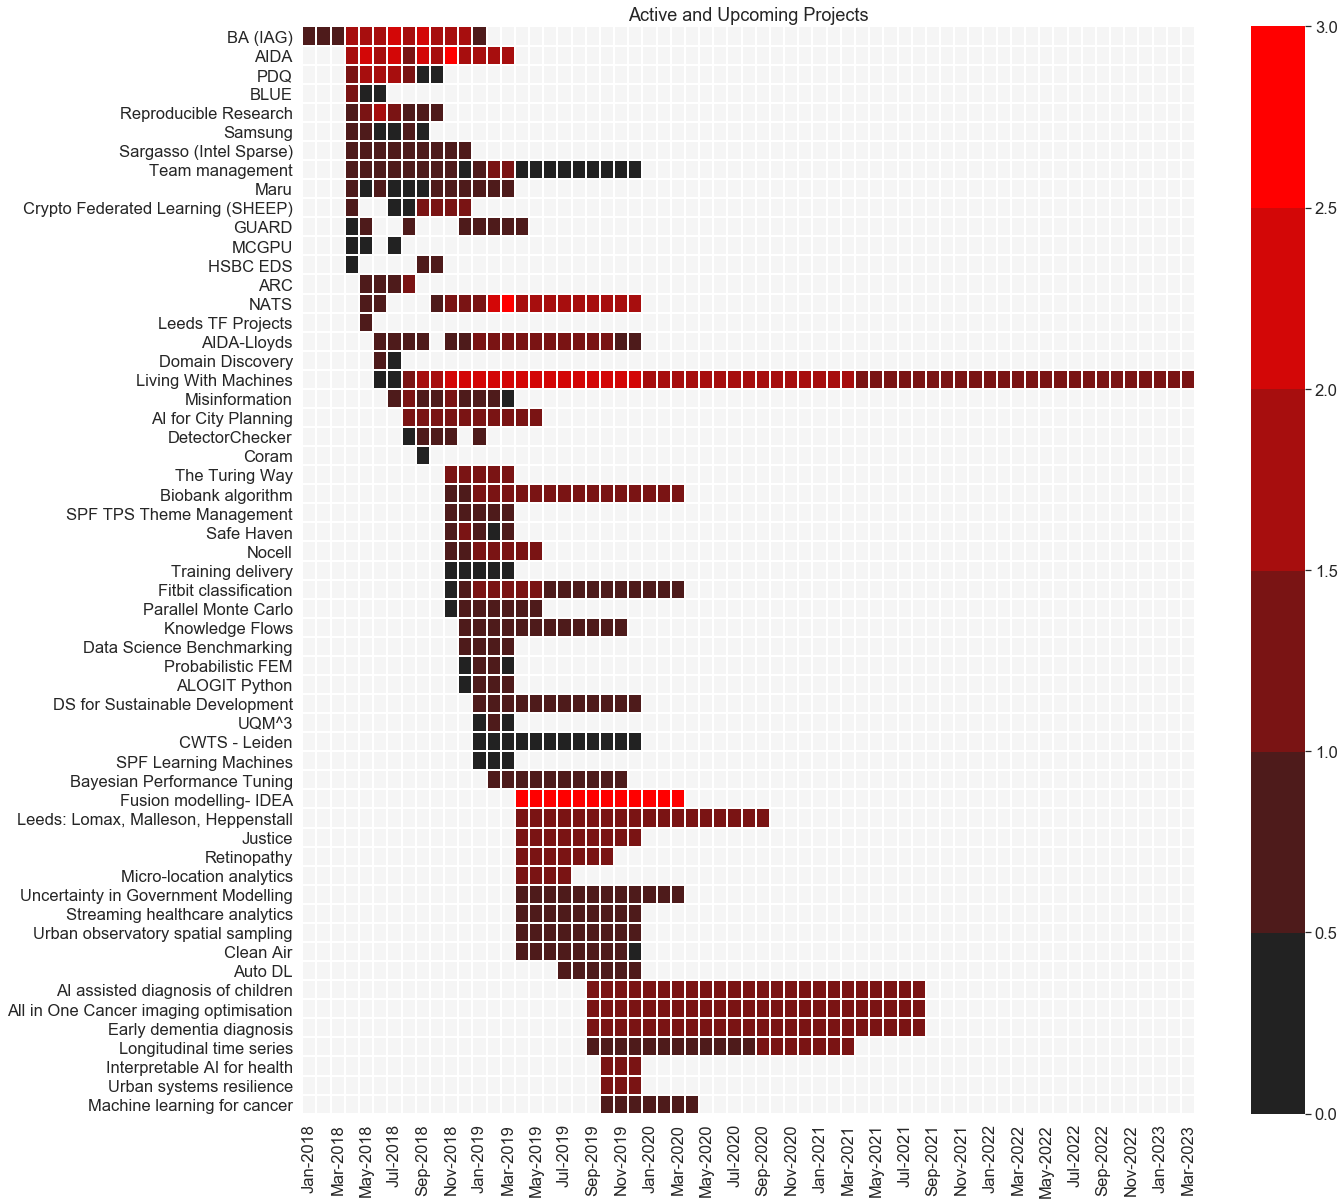

In [37]:
# project start/end dates
df = project_reqs.copy()
df = df.resample('MS').mean()
df = df.loc[:, df.sum()>0]
df.columns = [get_project_name(project_id) for project_id in df.columns]
df = pd.DataFrame(df, index=df.index.strftime("%b-%Y"))

plt.figure(figsize=(20,20))
sns.heatmap(df.T.sort_values(by=[col for col in df.T.columns],ascending=False), cmap=sns.dark_palette("red"), linewidths=1),#.sort_index(), 
sns.heatmap(df.T.sort_values(by=[col for col in df.T.columns],ascending=False)==0,
            mask=df.T.sort_values(by=[col for col in df.T.columns],ascending=False)!=0,
            cmap=ListedColormap(['whitesmoke']), linewidths=1, cbar=False),#.sort_index(), 

plt.title('Active and Upcoming Projects')

Text(0.5, 1.0, 'Project Resources Required')

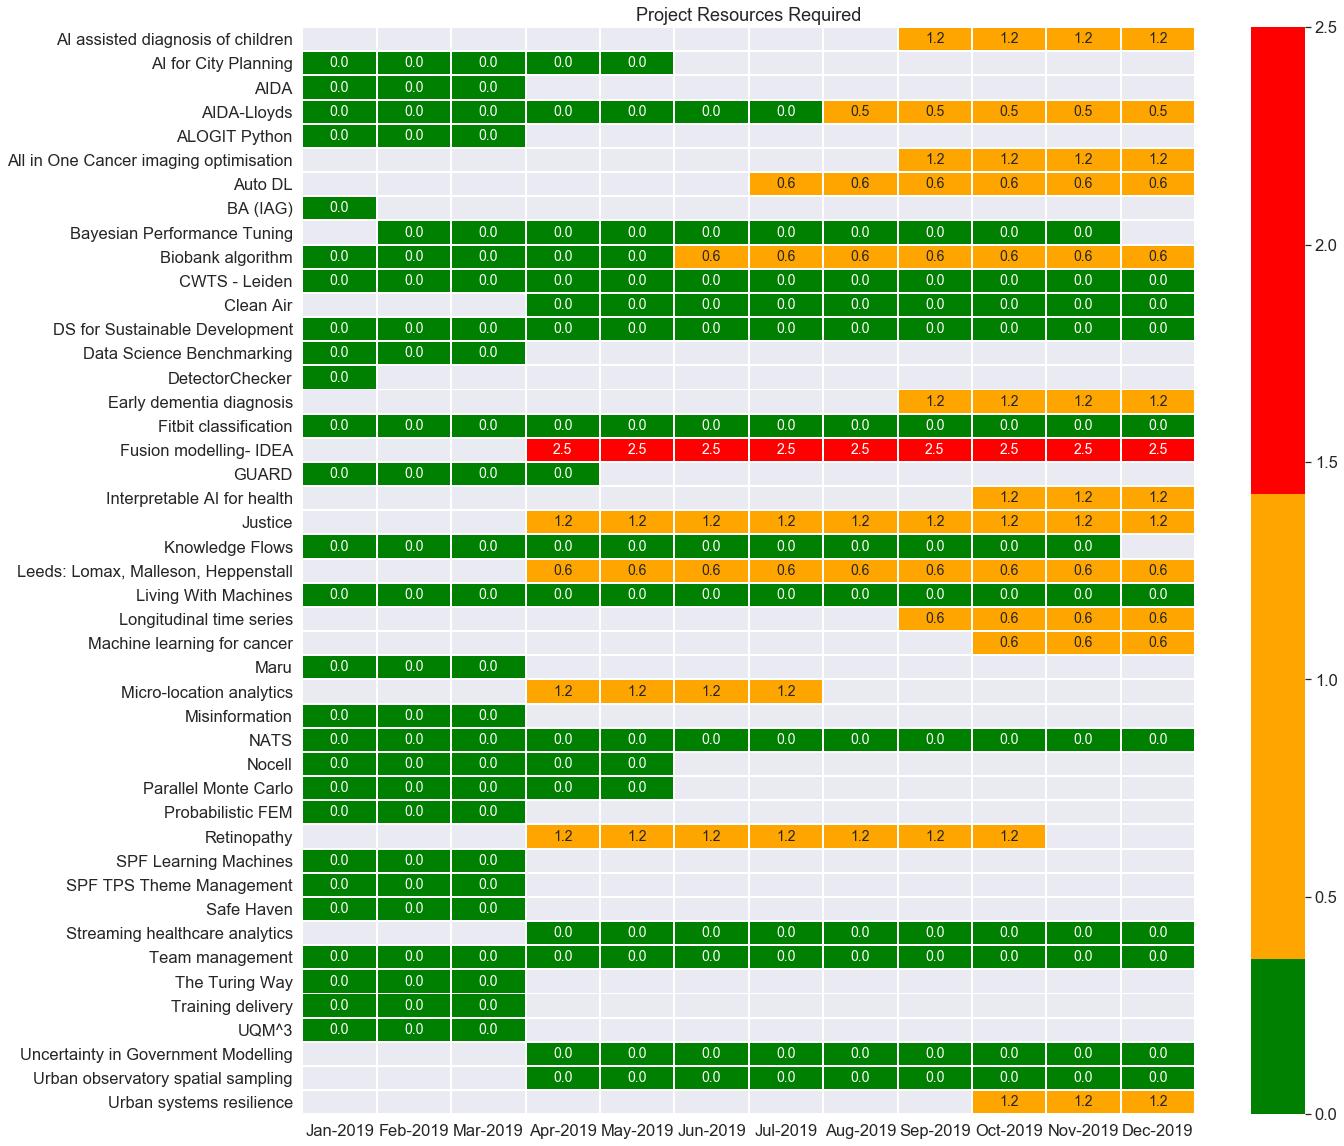

In [66]:
diff = project_resreq.copy()
reqs = project_reqs.copy()

mask = (diff.index >= pd.to_datetime(widg_team_start.value)) & (diff.index <= pd.to_datetime(widg_team_end.value))
diff = diff[mask].resample('MS').mean()
reqs = reqs[mask].resample('MS').mean()

diff = diff.loc[:, reqs.abs().sum()>0]
reqs = reqs.loc[:, reqs.abs().sum()>0]

diff.columns = [get_project_name(project_id) for project_id in diff.columns]
reqs.columns = [get_project_name(project_id) for project_id in reqs.columns]

diff = pd.DataFrame(diff, index=diff.index.strftime("%b-%Y"))
reqs = pd.DataFrame(reqs, index=reqs.index.strftime("%b-%Y"))

plt.figure(figsize=(20,20))

sns.heatmap(diff.T.sort_index(), cmap=ListedColormap(['green', 'orange','orange','orange','red','red', 'red']),linewidths=1, vmin=0,
           mask=reqs.T.sort_index()==0, annot=True,annot_kws={'fontsize':14}, fmt='.1f')


plt.title('Project Resources Required')

Text(0, 0.5, 'FTE (6.4hrs/day)')

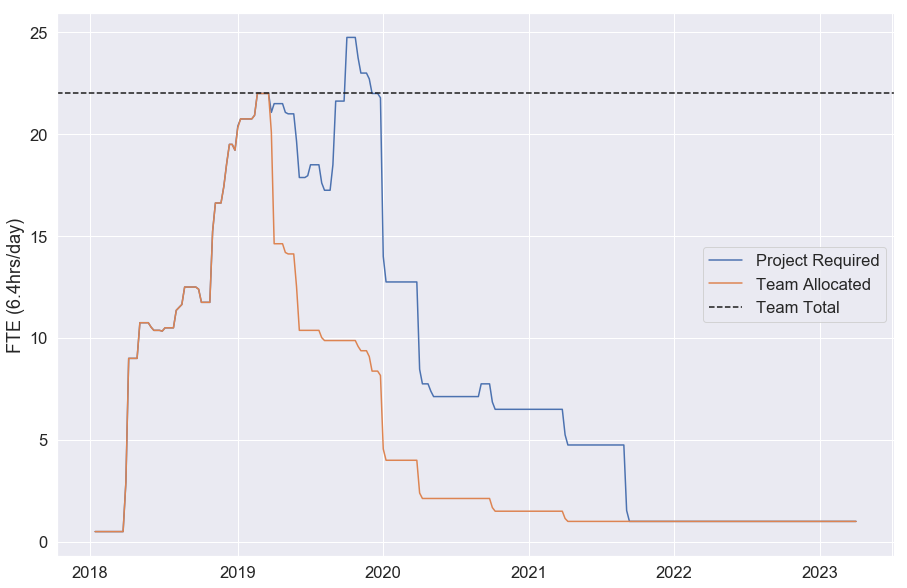

In [62]:
plt.figure(figsize=(15,10))

reqs = project_reqs.sum(axis=1).resample('W-MON').mean()

alloc = project_totals.copy()
alloc = alloc.sum(axis=1).resample('W-MON').mean()

# Weekly capacity just a constant based on number of people for now -
# no way to know e.g. when people started/stopped in REG in current data
team100 = people['weekly_capacity'].sum()

reqs.plot(label='Project Required')
alloc.plot(label='Team Allocated')
xlim=plt.xlim()
plt.plot(plt.xlim(),[team100,team100],'k--',label='Team Total')
plt.xlim(xlim)
plt.legend()
plt.ylabel('FTE (6.4hrs/day)')

## Equivalent of Projects sheet

In [ ]:
def spreadsheet_sheet(data_dict, key_type, start_date, end_date, freq):
    # Create a dataframe with everyone's 1st, 2nd and 3rd projects based on allocated time.
    alloc_projs = {}

    # set of unique project names used for cell colouring later
    names = set()

    # for each project
    for key in data_dict.keys():

        # get the projects's person allocations
        df = data_dict[key].copy()

        # extract the date range of interest
        df = select_date_range(df, start_date, end_date)

        # check there are project allocations to display
        rows,cols = df.shape
        if rows>0 and cols>0: 
            
            # replace ids with names. for project id: include resource required.
            if key_type=='project_id':
                df.columns = [get_person_name(person_id) for person_id in df.columns]
                df.columns.name = get_project_name(key)
                
                mask = (project_resreq.index >= start_date) & (project_resreq.index <= end_date)
                resreq = project_resreq.loc[mask]
                df['RESOURCE REQUIRED'] = resreq[key]
                
            elif key_type=='person_id':
                df.columns = [get_project_name(project_id) for project_id in df.columns]
                df.columns.name = get_person_name(key)
                
            else:
                return ValueError('key type must be person_id or project_id')
                
            # update the set of names
            [names.add(col) for col in df.columns]

            # resample the data to the given date frequency
            df = df.resample(freq).mean()

            # max number people assigned to this project at a time
            n_columns = (df>0).sum(axis=1).max()

            # initialise data frame to store projects people ranked by time assignment
            df_ranked = pd.DataFrame(index=df.index, columns=range(1, n_columns+1))

            # for each date period
            for date in df_ranked.index:

                # rank the people for this date period by time allocation
                sorted_people = df.loc[date, df.loc[date]>0].sort_values(ascending=False)

                if len(sorted_people)>0:
                    for i in range(len(sorted_people)):
                        # Fill with format <PERSON_NAME> (<PERSON_ALLOCATION>)
                        df_ranked.loc[date, i+1] = sorted_people.index[i] + ' ({:.1f})'.format(sorted_people.iloc[i])

                    # empty strings for ranks not needed for this date
                    df_ranked.loc[date, range(len(sorted_people)+1, n_columns+1)] = ''

                else:
                    df_ranked.loc[date,:] = ''


            # remove unused columns
            [df_ranked.drop(col,axis=1,inplace=True) for col in df_ranked.columns if df_ranked[col].str.len().sum()==0]

            # format dates nicely
            if freq=='MS':
                df_ranked = pd.DataFrame(df_ranked, index=df_ranked.index.strftime("%b-%Y"))
            elif freq=='W-MON':
                df_ranked = pd.DataFrame(df_ranked, index=df_ranked.index.strftime("%d-%b-%Y"))
            else:
                df_ranked = pd.DataFrame(df_ranked, index=df_ranked.index.strftime("%Y-%m-%d"))

            # store the project's allocations - transpose to get rows as projects and columns as dates
            alloc_projs[get_project_name(key)] = df_ranked.T

    # merge everyone together into one large dataframe, sorted by first name
    alloc_projs = pd.concat(alloc_projs).sort_index()

In [158]:
# Create a dataframe with everyone's 1st, 2nd and 3rd projects based on allocated time.
alloc_projs = {}

# select range and frequency of dates to display
start_date = pd.datetime(2018,11,1)
end_date = pd.datetime(2021,3,1)
freq = 'MS'

mask = (project_resreq.index >= start_date) & (project_resreq.index <= end_date)
resreq = project_resreq.loc[mask]

# set of unique project names used for cell colouring later
names = set()

# for each project
for project_id in project_allocations.keys():
    
    # get the projects's person allocations
    df = project_allocations[project_id].copy()

    # extract the date range of interest
    df = select_date_range(df, start_date, end_date)
    
    # check there are project allocations to display
    rows,cols = df.shape
    if rows>0 and cols>0:    
        # replace project_ids in column names with their project names
        df.columns = [get_person_name(person_id) for person_id in df.columns]
        df.columns.name = get_project_name(project_id)
        
        df['RESOURCE REQUIRED'] = resreq[project_id]
        
        # update the set of project names
        [names.add(pers) for pers in df.columns]

        # resample the data to the given date frequency
        df = df.resample(freq).mean()
        
        # max number people assigned to this project at a time
        n_columns = (df>0).sum(axis=1).max()
       
        # initialise data frame to store projects people ranked by time assignment
        df_ranked = pd.DataFrame(index=df.index, columns=range(1, n_columns+1))
                        
        # for each date period
        for date in df_ranked.index:
            
            # rank the people for this date period by time allocation
            sorted_people = df.loc[date, df.loc[date]>0].sort_values(ascending=False)
            
            if len(sorted_people)>0:
                for i in range(len(sorted_people)):
                    # Fill with format <PERSON_NAME> (<PERSON_ALLOCATION>)
                    df_ranked.loc[date, i+1] = sorted_people.index[i] + ' ({:.1f})'.format(sorted_people.iloc[i])

                # empty strings for ranks not needed for this date
                df_ranked.loc[date, range(len(sorted_people)+1, n_columns+1)] = ''
                
            else:
                df_ranked.loc[date,:] = ''
                
        
        # remove unused columns
        [df_ranked.drop(col,axis=1,inplace=True) for col in df_ranked.columns if df_ranked[col].str.len().sum()==0]

        # format dates nicely
        if freq=='MS':
            df_ranked = pd.DataFrame(df_ranked, index=df_ranked.index.strftime("%b-%Y"))
        elif freq=='W-MON':
            df_ranked = pd.DataFrame(df_ranked, index=df_ranked.index.strftime("%d-%b-%Y"))
        else:
            df_ranked = pd.DataFrame(df_ranked, index=df_ranked.index.strftime("%Y-%m-%d"))
        
        # store the project's allocations - transpose to get rows as projects and columns as dates
        alloc_projs[get_project_name(project_id)] = df_ranked.T
        
# merge everyone together into one large dataframe, sorted by first name
alloc_projs = pd.concat(alloc_projs).sort_index()

In [162]:
colors = {}
for pers in names:
    colors[pers] = generate_new_color(colors.values(), pastel_factor=0.9)

# Assign a different colour to each project
def highlight_name(cell):        
    cell = cell[:-6]
    if 'RESOURCE REQUIRED' in cell:
        return 'background-color: red; color: white; border: 5px solid black'
    
    elif cell in names:
        return 'background-color: '+rgb2hex(colors[cell])
    
    else:
        return 'background-color: white'

styled_df = alloc_projs.style.applymap(highlight_name)

# display
styled_df.to_excel('projects_coloured_people.xlsx')
display(styled_df)

To do:

Same views for projects

Include resources from other groups